# Evaluation of features 
1. comparison to clustering of gene space
2. silhouette score to evaluation "clusterability" of different features



In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from spatial_tools.image.tools import get_image_features

# path to "raw" dataset folder
BASE_PATH = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla"
dataset_name = "V1_Adult_Mouse_Brain"
dataset_folder = os.path.join(
    BASE_PATH, "20191205_10XVisium_MouseBrainCoronal_giovanni.palla"
)

adata = sc.read_visium(
    dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/icb/olle.holmberg/anaconda3/envs/hackathon-spatial/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Preprocess genes and calculate gene-space clustering

<AxesSubplot:xlabel='n_genes_by_counts'>

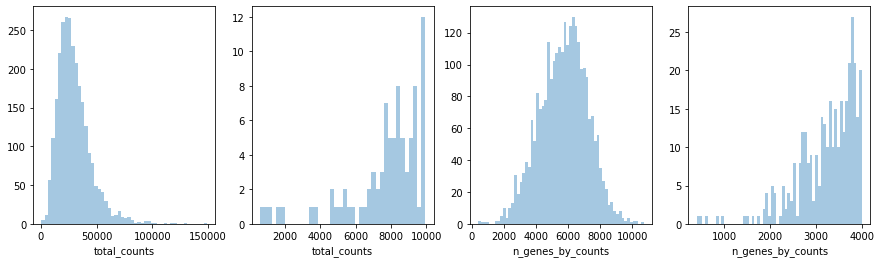

In [2]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

data looks fine, no thresholding needed for now.
Normalize data.

In [3]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

calculate gene-space clustering

In [4]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters_genes")

/home/icb/olle.holmberg/anaconda3/envs/hackathon-spatial/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


## Calculate features + feature-space clustering

In [5]:
# get features table
#features_abt(adata, dataset_folder, dataset_name, features=["hog"])
features = ["texture", "summary", "color_hist"]
adata.obsm["image_features"] = get_image_features(adata, dataset_folder, dataset_name, features=features)

2698it [02:22, 18.90it/s]


In [6]:
adata.obsm['X_features_pca'] = sc.pp.pca(adata.obsm['image_features'])
sc.pp.neighbors(adata, use_rep='X_features_pca')
adata.obsm['X_features_umap'] = sc.tl.umap(adata, copy=True).obsm['X_umap']
sc.tl.leiden(adata, key_added='clusters_features')

/home/icb/olle.holmberg/anaconda3/envs/hackathon-spatial/lib/python3.6/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


In [ ]:
adata.obsm['X_features1_pca'] = sc.pp.pca(adata.obsm['features1'])
sc.pp.neighbors(adata, use_rep='X_features1_pca')
adata.obsm['X_features1_umap'] = sc.tl.umap(adata, copy=True).obsm['X_umap']
sc.tl.leiden(adata, key_added='clusters_features1')

## Plot resulting clusters

In [ ]:
sc.pl.spatial?

/home/icb/olle.holmberg/anaconda3/envs/hackathon-spatial/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical
... storing 'genome' as categorical


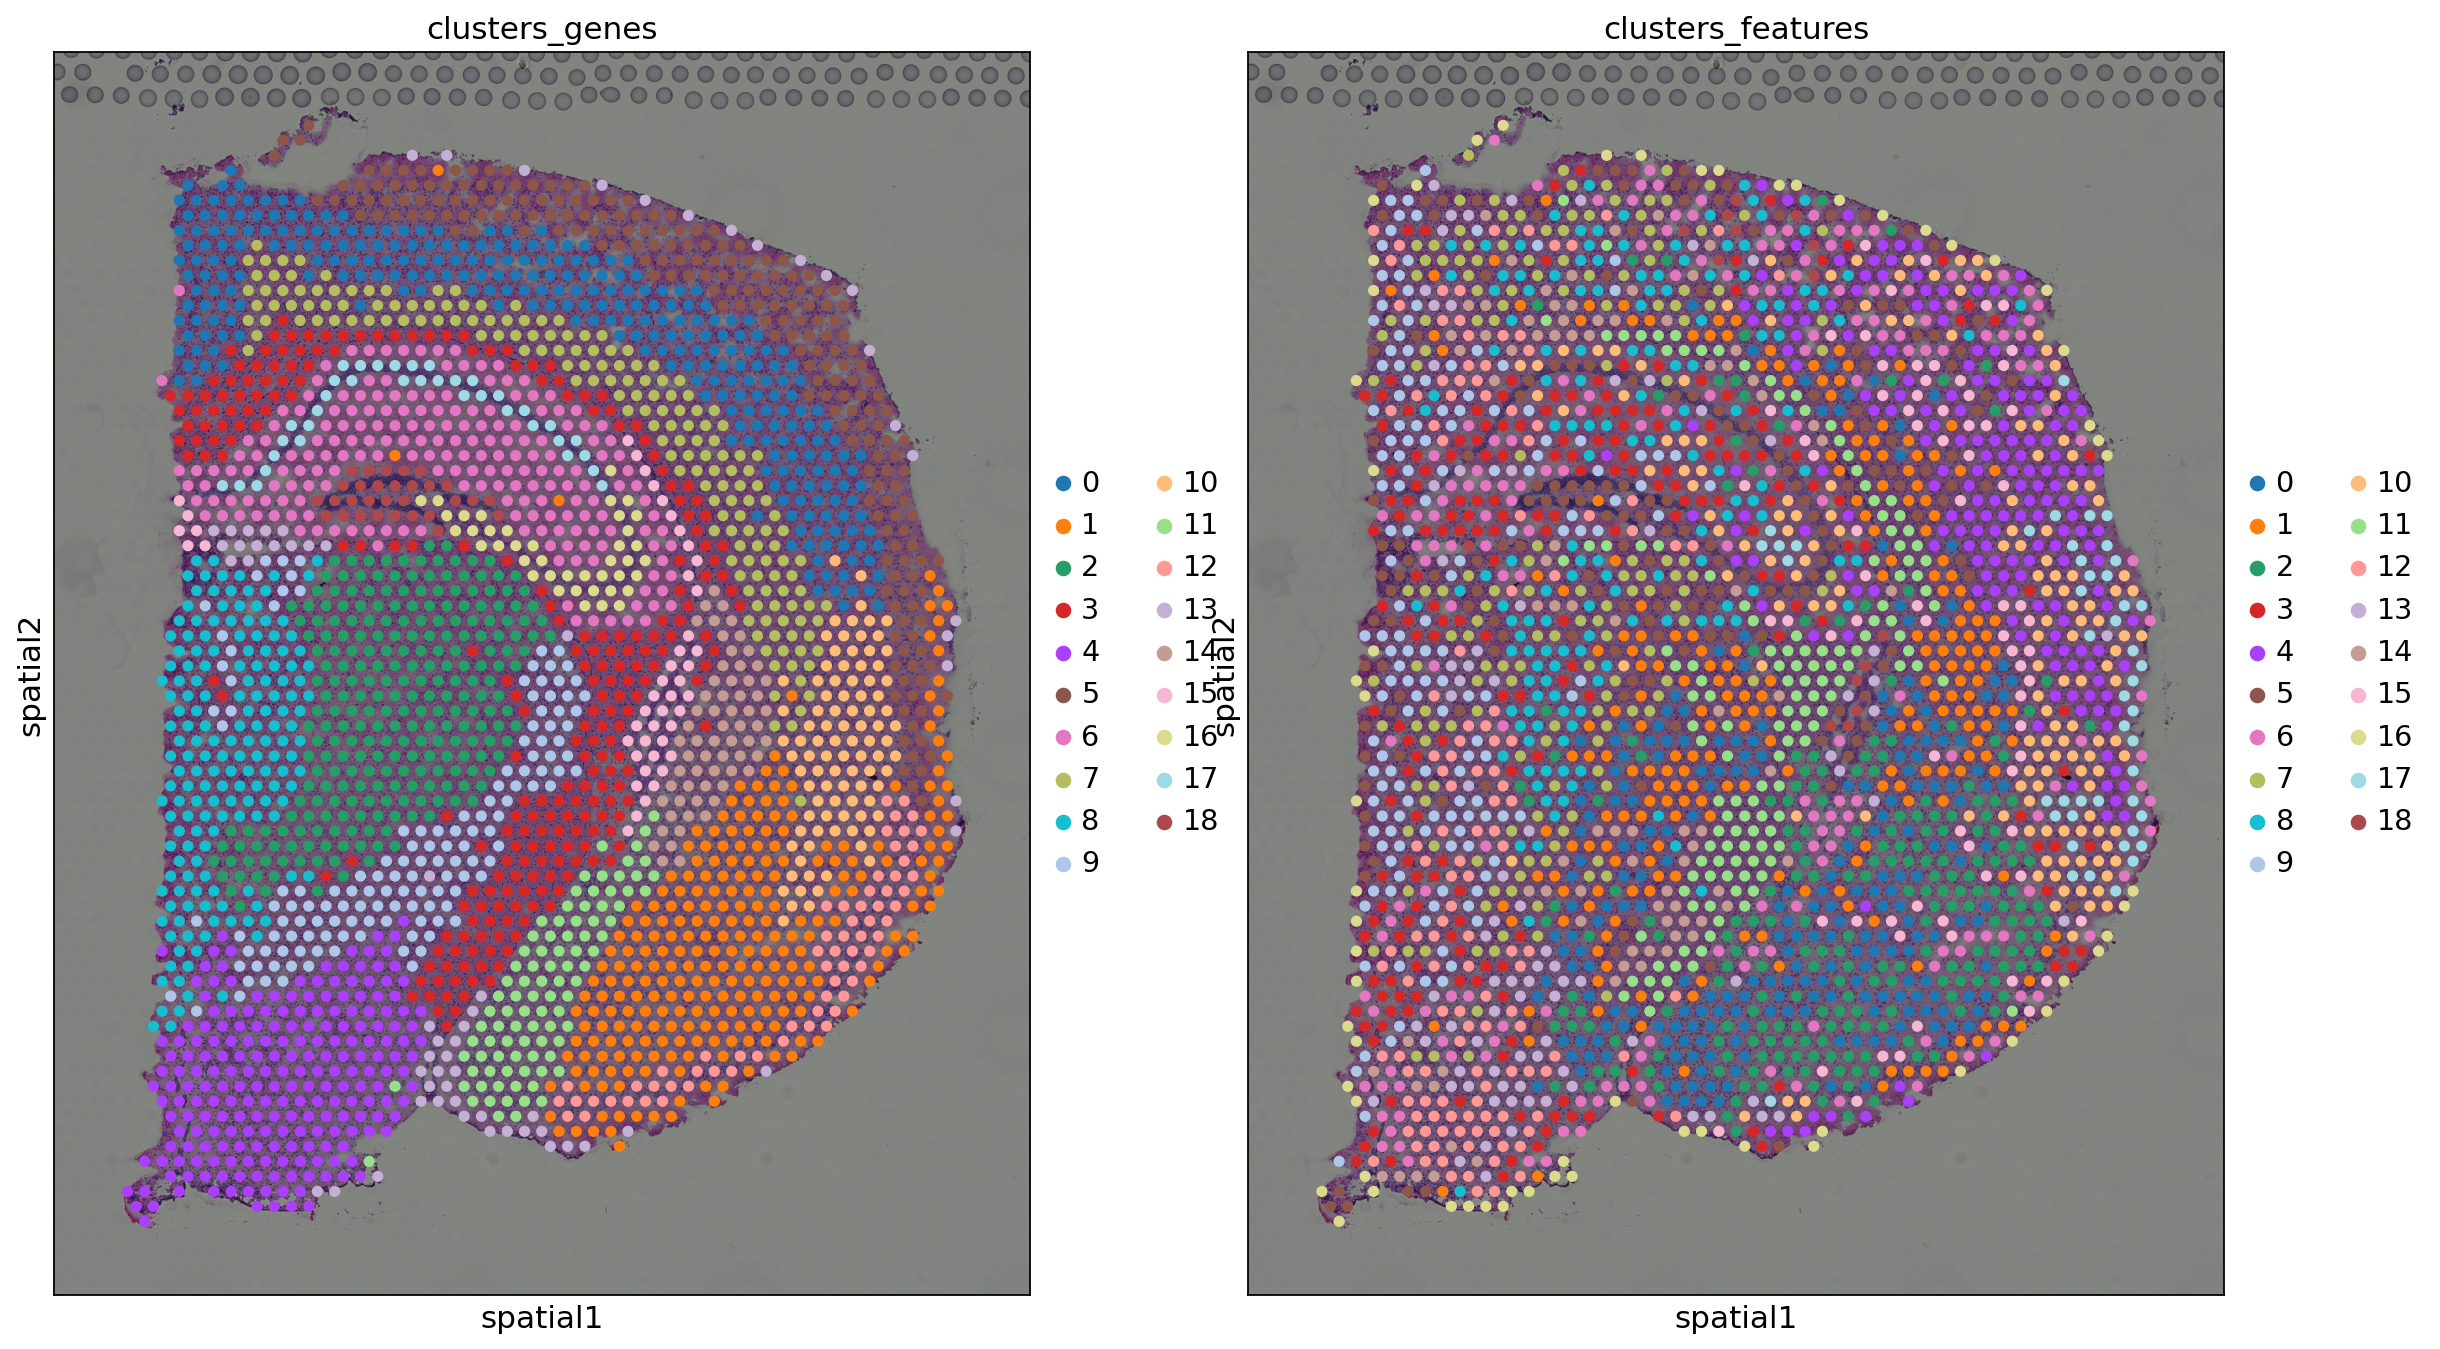

In [7]:
sc.set_figure_params(facecolor="white", figsize=(8, 15))
sc.pl.spatial(adata, color=['clusters_genes', 'clusters_features'], save='clustering_comparison.png')

#### HOG features

## Evaluation: silhouette score
Between -1 and 1, 1 means most compact and different clusters

In [8]:
import sklearn

In [9]:
s = sklearn.metrics.silhouette_score(adata.obsm['X_pca'], adata.obs['clusters_genes'])
print(f"Silhouette score of gene-space clusters: {s}")

s = sklearn.metrics.silhouette_score(adata.obsm['X_features_pca'], adata.obs['clusters_features'])
print(f"Silhouette score of feature-space clusters: {s}")

Silhouette score of gene-space clusters: 0.1636158674955368
Silhouette score of feature-space clusters: 0.10056820511817932


## Evaluation: cluster overlap with GT (gene-space) clusters
adjusted rand score: 

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:

`ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)`
The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation).

In [ ]:
sklearn.metrics.adjusted_rand_score(adata.obs['clusters_genes'], adata.obs['clusters_features'])